<a href="https://colab.research.google.com/github/arifchuuw/LIGO_GW_Tutorials/blob/main/Lab2_solved_ZL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 Report: 
## Iris Classification with Regression

### Name:

In [ ]:
# Import neccessary packages

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch

In [ ]:
x = torch.rand(5,3)
print(x)

tensor([[0.1839, 0.5952, 0.0556],
        [0.6354, 0.3976, 0.6595],
        [0.7383, 0.2315, 0.1741],
        [0.3237, 0.6859, 0.9570],
        [0.3557, 0.2023, 0.5811]])


In [ ]:
torch.cuda.is_available()

True

In [ ]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [ ]:
#Image('/content/lab2_exercise1.png', width = 1000)

## Prepare Data

In [ ]:
from sklearn.datasets import load_iris

# iris dataset is available from scikit-learn package
iris = load_iris()

# Load the X (features) and y (targets) for training
X_train = iris['data']
y_train = iris['target']

# Load the name labels for features and targets
feature_names = iris['feature_names']
names = iris['target_names']

# Feel free to perform additional data processing here (e.g. standard scaling)

In [ ]:
# Print the first 10 training samples for both features and targets

print(X_train[:10, :], y_train[:10]) 

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]] [0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Print the dimensions of features and targets

print(X_train.shape, y_train.shape)

(150, 4) (150,)


In [ ]:
print(type(X_train[0][0]))

<class 'numpy.float64'>


In [ ]:
# feature_names contains name for each column in X_train
# For targets, 0 -> setosa, 1 -> versicolor, 2 -> virginica

print(feature_names, names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] ['setosa' 'versicolor' 'virginica']


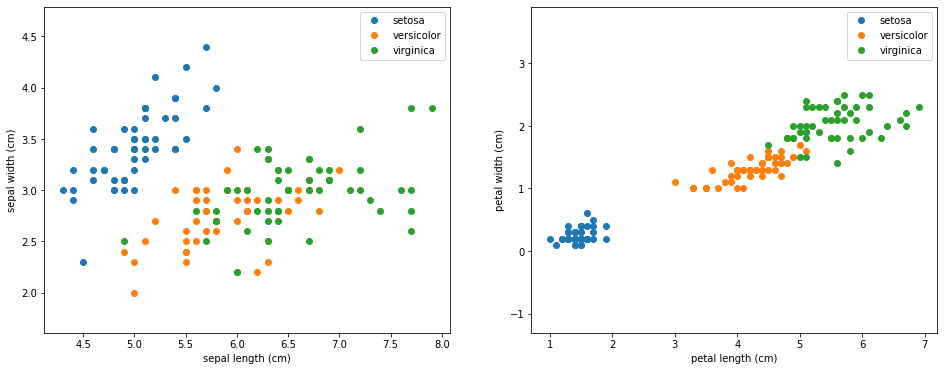

In [ ]:
# We can visualize the dataset before training

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# enumerate picks up both the index (0, 1, 2) and the element ('setosa', 'versicolor', 'virginica') from "names"
# loop 1: target = 0, target_name = 'setosa'
# loop 2: target = 1, target_name = 'versicolor' etc

for target, target_name in enumerate(names):
    
    # Subset the rows of X_train that fall into each flower category using boolean mapping
    X_plot = X_train[y_train == target]

    # iris target?? all the same??
    
    # Plot the sepal length versus sepal width for the flower category
    ax1.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)

# Label the plot
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend()

# Repeat the above process but with petal length versus petal width
for target, target_name in enumerate(names):
    
    X_plot = X_train[y_train == target]
    
    ax2.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
    
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend()

In [ ]:
# scaling function

def scale_data(arr):
    # get row number, since row is first dimension, column the second
    length = arr.shape[1]
    scaled_data = [None] * arr.shape[0]

    for i in range(length):
      arr_x = arr[:, i]
      mu = arr_x.mean()
      sigma = arr_x.std()
      arr_x = (arr_x - mu)/sigma
      scaled_data = np.vstack([scaled_data, arr_x])
    
    scaled_data = scaled_data[1:, :].T
    return scaled_data

In [ ]:
# scale x y
s_l = scale_data(X_train)
s_l = np.array(s_l, dtype = float)

#print(type(s_l))
X_train = s_l
y_train = np.array([y_train]).T
print(y_train.shape)

(150, 1)


## Define Model

In [ ]:
class irisClassification(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        
        super(irisClassification, self).__init__()
        
        self.layer1 = torch.nn.Linear(input_dim, hidden_dim)
        self.layer2 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)

        return x

## Define Hyperparameters

In [ ]:
hidden = 10
model = irisClassification(input_dim = 4, output_dim = 1, hidden_dim = hidden)

learning_rate = 0.01
epochs  = 50

# We will use gradient descent for our optimizer and Mean Squared Error Loss function
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Run this line if you have PyTorch GPU version
if torch.cuda.is_available():
    model.cuda()

## Identify Tracked Values

In [ ]:
train_loss_list = []

## Train Model

In [ ]:
if torch.cuda.is_available():
    inputs = torch.from_numpy(X_train).float().cuda() # If using GPU version, transfer the dataset to GPU memory
    targets = torch.from_numpy(y_train).float().cuda()

else:
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).float()

In [ ]:
print(targets.size())

torch.Size([150, 1])


In [ ]:
# reset list every time test
testlist = []
targetlist = []

train_loss_list = []
for epoch in range(epochs):
    
    optimizer.zero_grad()
    outputs = model(inputs)
    
    # compute and save loss values
    loss = loss_func(outputs, targets)
    train_loss_list.append(loss.item())

    # record progress
    if epoch%5 == 0:
      with torch.no_grad():
        testlist.append(outputs.cpu().numpy())
        targetlist.append(targets.cpu().numpy())

    loss.backward()
    optimizer.step()

    #print('epoch {}, loss {}'.format(epoch, loss.item()))

In [ ]:
print(targets.size())

torch.Size([150, 1])


## Visualize and Evaluate Model

50


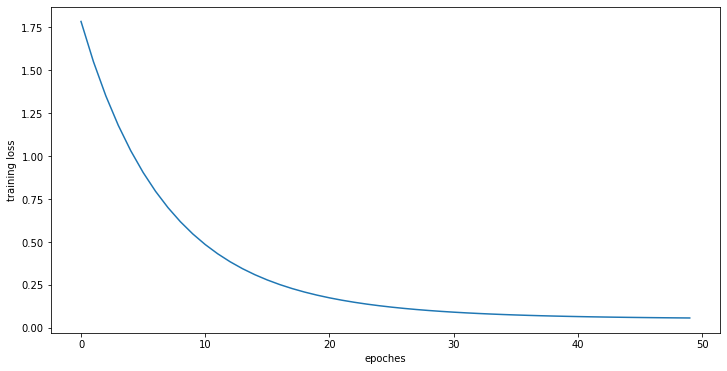

In [ ]:
# Plot your training loss throughout the training
# Include proper x and y labels for the plot

plt.figure(figsize=(12, 6))

epoch_list = np.arange(epochs)

plt.plot(epoch_list, train_loss_list)
plt.ylabel('training loss')
plt.xlabel('epoches')
print(len(train_loss_list))

In [ ]:
# Confirm that your model's training accuracy is >90%
n_correct = 0.

with torch.no_grad():
    
    # Compare your model predictions with targets (y_train) to compute the training accuracy     
    predicted = model(torch.from_numpy(X_train).float().cuda()).cpu().numpy()
    predicted_result = np.round_(predicted)

    for i in range(len(predicted_result)):
      if predicted_result[i][0] == y_train[i]:
          n_correct = n_correct+1

Train_acc = n_correct / len(predicted_result)
# Training accuracy = (# of correct predictions) / (total # of training samples)
# You can round the model predictions to integer (e.g. 0.34 -> 0, 1.78 -> 2)
print(Train_acc)

0.96


0


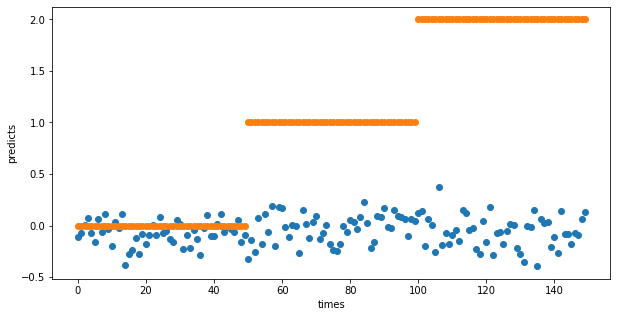

5


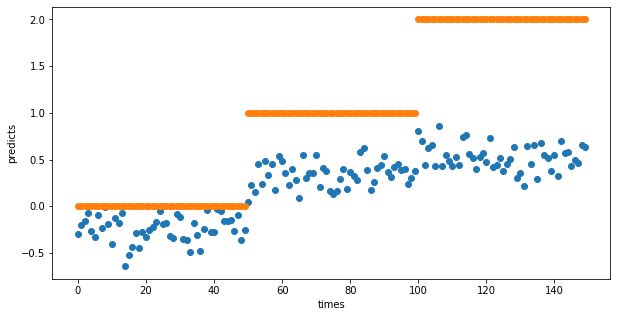

10


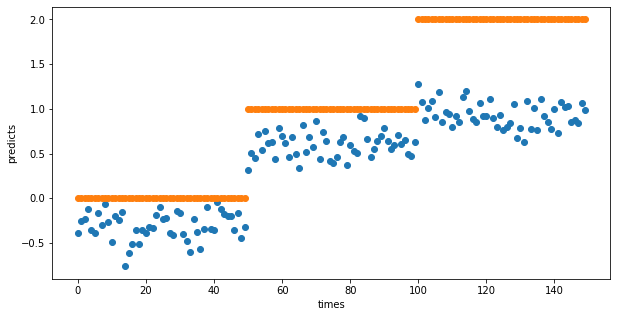

15


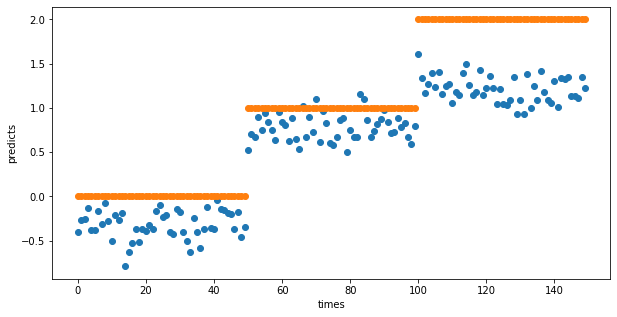

20


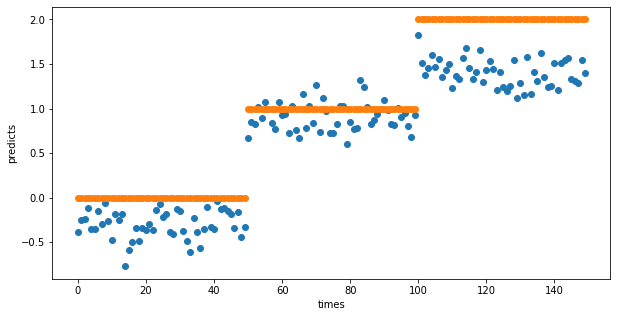

25


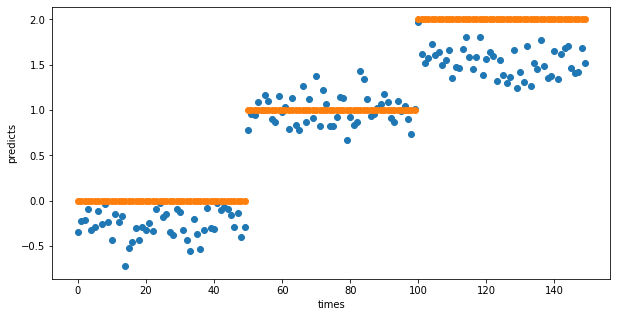

30


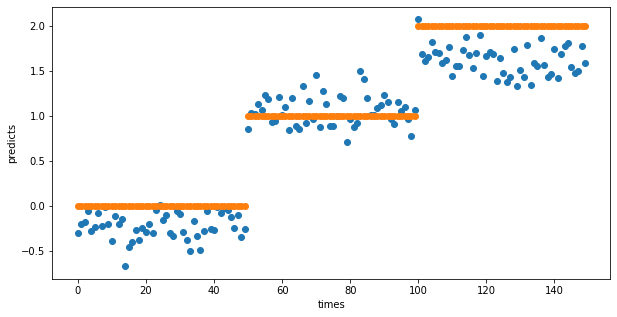

35


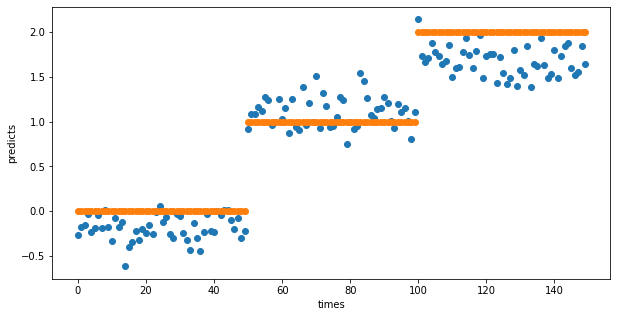

40


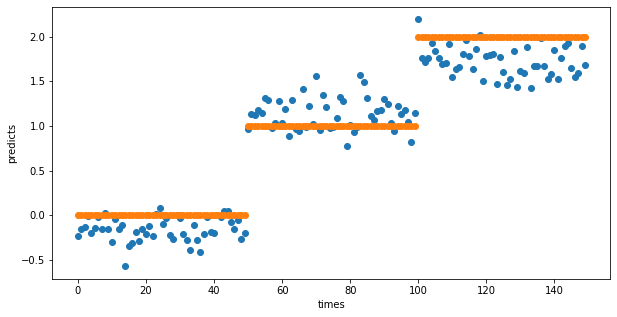

45


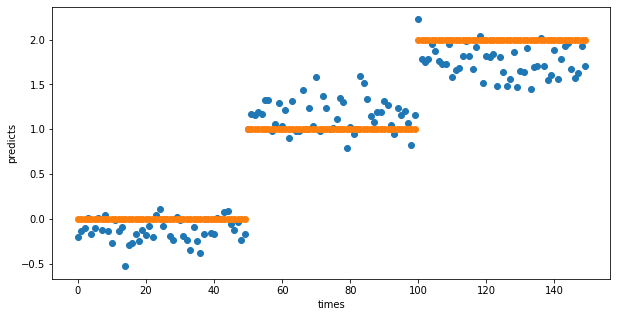

In [ ]:
for i in range(len(testlist)):
  plt.figure(figsize = (10, 5))

  xvalue = range(150)
  plt.scatter(xvalue, testlist[i])
  plt.scatter(xvalue, targetlist[i])
  print(i*5)
# Add proper x-label and y-label 

  plt.xlabel('times')
  plt.ylabel('predicts')

  plt.show()

In [ ]:
%%shell
jupyter nbconvert -- to html /content/Lab2_solved_ver.ipynb

[NbConvertApp] WARNING | pattern 'to' matched no files
[NbConvertApp] WARNING | pattern 'html' matched no files
[NbConvertApp] Converting notebook /content/Lab2_solved_ver.ipynb to html
[NbConvertApp] Writing 520360 bytes to /content/Lab2_solved_ver.html
